[*********************100%***********************]  1 of 1 completed


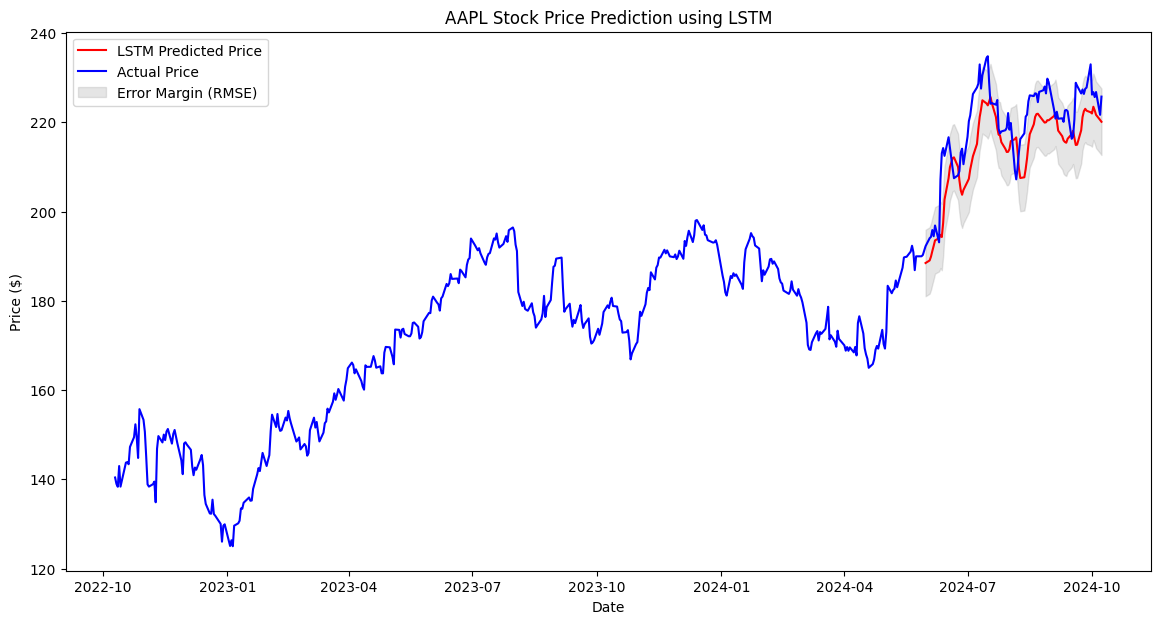

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from datetime import datetime, timedelta

# 1. 데이터 수집
start = (datetime.now() - timedelta(days=730)).strftime('%Y-%m-%d')  # 데이터 시작 날짜
end = datetime.now().strftime('%Y-%m-%d')    # 데이터 종료 날짜
ticker = 'AAPL'       # 주식 티커
df = yf.download(ticker, start=start, end=end)  # yfinance를 사용하여 데이터 다운로드

# 2. 데이터 전처리
data = df['Close'].values.reshape(-1, 1)  # 종가를 2D 배열로 변형
scaler = MinMaxScaler(feature_range=(0, 1))  # 데이터 정규화
scaled_data = scaler.fit_transform(data)  # 데이터 정규화 수행

# 데이터셋 분할: 훈련 데이터와 테스트 데이터
train_data, test_data = train_test_split(scaled_data, test_size=0.3, shuffle=False)  # 30% 테스트 데이터

# LSTM 입력 형식에 맞게 데이터 변형
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # 입력 데이터
        y.append(data[i + time_step, 0])      # 타겟 데이터
    return np.array(X), np.array(y)

# 시간 단계 설정
time_step = 60  # 60일의 데이터를 사용하여 예측
X_train, y_train = create_dataset(train_data, time_step)  # 훈련 데이터 생성
X_test, y_test = create_dataset(test_data, time_step)      # 테스트 데이터 생성

# LSTM 입력 형태로 변형 (3D 배열)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 성능 검사
epoch = 300
dropout = 0.2
# 3. LSTM 모델 구축
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(dropout))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(dropout))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련 (verbose=0으로 설정하여 출력 숨김)
history = lstm_model.fit(X_train, y_train, epochs=epoch, validation_split=0.3, batch_size=32, verbose=0)

# 4. 예측 수행
lstm_predicted_prices = lstm_model.predict(X_test, verbose=0)  # verbose=0으로 설정하여 출력 숨김

# 예측 결과를 원래 스케일로 변환
lstm_predicted_prices = scaler.inverse_transform(lstm_predicted_prices)

# 5. 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(df.index[len(train_data) + time_step + 1:], lstm_predicted_prices, color='red', label='LSTM Predicted Price')
plt.plot(df.index, data, color='blue', label='Actual Price')

# 가능성 있는 오차 범위 생성
rmse = np.sqrt(np.mean((data[-len(lstm_predicted_prices):] - lstm_predicted_prices) ** 2))
upper_bound = lstm_predicted_prices + rmse
lower_bound = lstm_predicted_prices - rmse

plt.fill_between(df.index[len(train_data) + time_step + 1:], lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.2, label='Error Margin (RMSE)')

plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

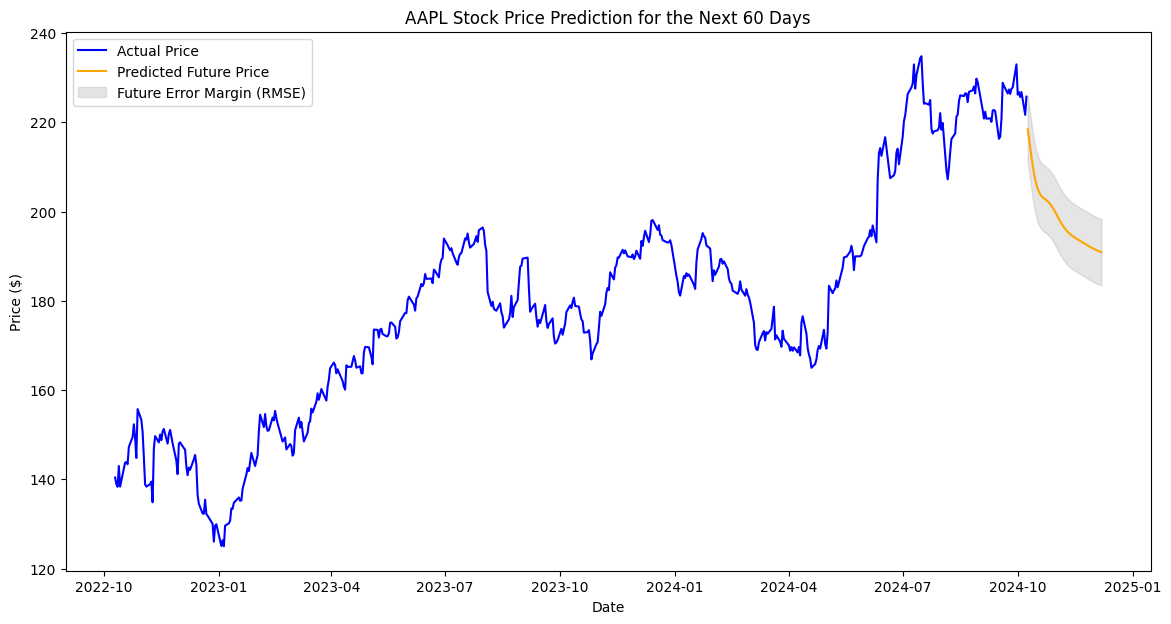

,Predicted Price
2024-10-09,218.444077
2024-10-10,216.620361
2024-10-11,214.454422
2024-10-12,212.313522
2024-10-13,210.352142
2024-10-14,208.637802
2024-10-15,207.194580
2024-10-16,206.020493
2024-10-17,205.096146
2024-10-18,204.390686


In [2]:
# 6. 미래 데이터 예측
last_data = scaled_data[-time_step:].reshape(1, time_step, 1)

# 예측할 미래 기간 설정
future_days = 60
future_prices = []

# RMSE 계산
val_rmse = np.sqrt(np.mean((data[-len(lstm_predicted_prices):] - lstm_predicted_prices) ** 2))

for _ in range(future_days):
    predicted_price = lstm_model.predict(last_data, verbose=0)
    future_prices.append(predicted_price[0, 0])
    last_data = np.append(last_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# 미래 가격을 원래 스케일로 변환
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

# 7. 미래 예측 결과 시각화
future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=future_days)

plt.figure(figsize=(14, 7))
plt.plot(df.index, data, color='blue', label='Actual Price')
plt.plot(future_dates, future_prices, color='orange', label='Predicted Future Price')

# 미래 예측의 상한선과 하한선 시각화
future_upper_bound = future_prices + val_rmse
future_lower_bound = future_prices - val_rmse

plt.fill_between(future_dates, future_lower_bound.flatten(), future_upper_bound.flatten(), color='gray', alpha=0.2, label='Future Error Margin (RMSE)')

plt.title(f'{ticker} Stock Price Prediction for the Next {future_days} Days')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 8. 예상 주가 출력
predicted_prices_df = pd.DataFrame(future_prices, index=future_dates, columns=['Predicted Price'])
predicted_prices_df